In [1]:
import drjit as dr
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from mitsuba import Float,Point2f 
from PDE2D import GreenSampling, Split
import time

In [2]:
max_z = 5
rad = 1
source_rad = rad/2
source_val = 50.
newton_steps = 3
use_accel = True
split = Split.Normal
max_split = 250

In [3]:
source_p = {}
source_p["radius"] = source_rad
source_p["val"] = source_val
def source_generator(points, params):
    return dr.select(dr.norm(points) < params["radius"], params["val"], 0.0)

In [4]:
s = 1
bbox = [[-1.05 * rad * s, -1.05 * rad * s], [1.05 * rad * s, 1.05 * rad * s]]
resolution_image = [256, 256]
spp_image = 256
epsilon = 1e-5

dirichlet = ConstantCoefficient("dirichlet", 0)
neumann = ConstantCoefficient("neumann",0)
σ = ConstantCoefficient("screening", 0)

out_val = 1
image =                              np.array ([[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 0, 0, 0,.5,.5,.5,.5,.5,.5,.2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0,.2,.5,.5, 1, 2, 2, 2, 2, 2,.5,.5, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0,.2,.5, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0,.5, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,.5,.5, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,.5, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0,.2,.5, 1, 1, 1, 2, 2, 2, 2,.5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 0,.2,.2,.5, .5, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                                [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype = np.float64)
image *= 2
image += out_val
α = DiskTextureCoefficient("diffusion", image, radius = rad, constant_thickness= 0.001, origin = [0,0], out_val = out_val)

f = FunctionCoefficient("source", source_p, source_generator)
shape = CircleShape(origin=Point2f(0., 0.), radius=rad, epsilon= epsilon,dirichlet=[dirichlet])
data_holder = DataHolder(shape = shape, σ = σ, f=f, α = α)

/home/ekrem/repos/MC-PDE3D/PDE2D/utils/sketch.py:46: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 5 Axes> than <Figure size 2000x500 with 4 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, cax=cax)


Eval type : polynomial, sampling type : newton, time = 0.562 s


/home/ekrem/repos/MC-PDE3D/PDE2D/utils/sketch.py:46: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 6 Axes> than <Figure size 2000x500 with 5 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, cax=cax)


Eval type : polynomial, sampling type : rejection, time = 0.617 s


/home/ekrem/repos/MC-PDE3D/PDE2D/utils/sketch.py:46: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 7 Axes> than <Figure size 2000x500 with 6 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, cax=cax)


Eval type : analytic, sampling type : newton, time = 9.002 s


/home/ekrem/repos/MC-PDE3D/PDE2D/utils/sketch.py:46: UserWarning: Adding colorbar to a different Figure <Figure size 2000x500 with 8 Axes> than <Figure size 2000x500 with 7 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(im, cax=cax)


Eval type : analytic, sampling type : rejection, time = 3.908 s


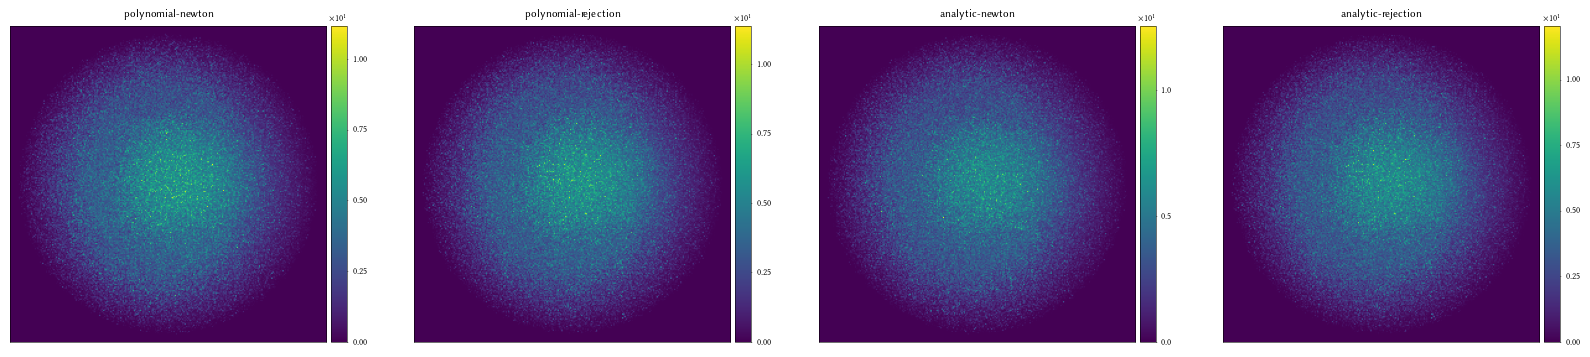

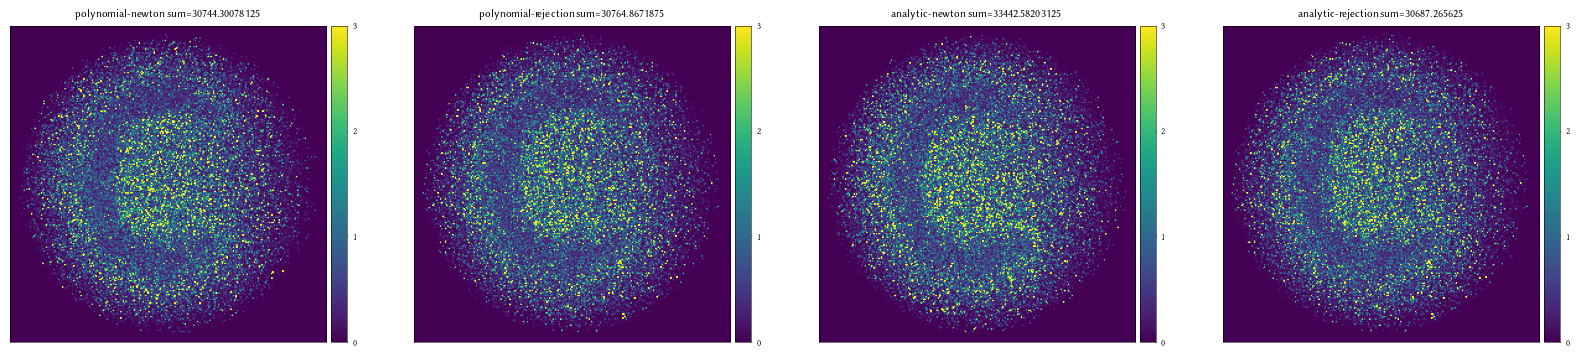

In [5]:

figure1, ax1 = plt.subplots(1,4, figsize = (20,5))
figure2, ax2 = plt.subplots(1,4, figsize = (20,5))
points = create_image_points(bbox, resolution_image, spp_image, centered = True)
i = 0
for type1 in ["polynomial", "analytic"]:
    for type2 in ["newton", "rejection"]:
        
        if (type1 == "polynomial") and (type2 == "newton"):
            wos = WosVariable(data_holder, seed = 21, green_sampling= GreenSampling.Polynomial, newton_steps = newton_steps, use_accelaration = use_accel, max_z = 5)
        elif (type1 == "analytic") and (type2 == "newton"):
            wos = WosVariable(data_holder, seed = 21, green_sampling= GreenSampling.Analytic, newton_steps=newton_steps, use_accelaration= use_accel, max_z = max_z)
        elif (type1 == "polynomial") and (type2 == "rejection"):
            wos = WosVariableRejection(data_holder, seed = 21, green_sampling= GreenSampling.Polynomial, newton_steps=newton_steps, use_accelaration = use_accel, max_z = 5)
        elif (type1 == "analytic") and (type2 == "rejection"):
            wos = WosVariableRejection(data_holder, seed = 21, green_sampling= GreenSampling.Analytic, newton_steps = newton_steps, use_accelaration = use_accel, max_z = max_z)
        else:
            raise Exception("No such case.")
        dr.sync_thread()
        t = time.time()
        L_wos, particle= wos.solve(points_in = points, verbose = False, split = split, max_depth_split=max_split)
        image_wos, tensor, image_variance, tensor_variance = create_image_from_result(L_wos, resolution_image, compute_std=True)
        dr.eval(tensor)
        dr.sync_thread()
        t_last = time.time()
        plot_image(image_wos[0], ax1[i])
        plot_image(image_variance[0], ax2[i], input_range = [0,3])
        ax1[i].set_title(f"{type1}-{type2}")
        ax2[i].set_title(f"{type1}-{type2} sum={np.sum(image_variance[0])}")
        i += 1
        print(f"Eval type : {type1}, sampling type : {type2}, time = {(t_last - t):.3f} s")
